In [2]:
from os.path import join as path_join

import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from holoviews.ipython import display
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import zscore



In [3]:
data_root = kagglehub.dataset_download("andrewkronser/cve-common-vulnerabilities-and-exposures")


In [14]:
## 📌 1. Loading the Dataset

# >## 💡 **Interpretation**:
# -  **mod_date: The date the entry was last modified.**
# -  **pub_date: The date the entry was published.**
# -  **cvss: Common Vulnerability Scoring System (CVSS) score, a measure of the severity of a vulnerability.**
# -  **cwe_code: Common Weakness Enumeration (CWE) code, identifying the type of weakness.**
# -  **cwe_name: The name associated with the CWE code.**
# -  **summary: A text summary of the vulnerability.**
# -  **access_authentication.**
# -  **access_complexity: how difficult it is to execute.**
# -  **access_vector: how the attack is performed, aka via network or locally.**

df = pd.read_csv(path_join(data_root, 'cve.csv'), header=0, index_col=0)
df.mod_date = pd.to_datetime(df.mod_date)
df.pub_date = pd.to_datetime(df.pub_date)

# Check for missing values before summary statistics
print("\nMissing Values:")
print(df.isnull().sum())

# Dataset summary
print(df)
print("\nDataset Info:")
df.info()


non_par_com = {"NONE": 0, "COMPLETE": 2, "PARTIAL": 1}
low_med_hih = {"LOW": 0, "MEDIUM": 1, "HIGH": 2}
non_sin_mul = {"NONE": 0, "SINGLE": 1, "MULTIPLE": 2}
loc_adj_net = {"LOCAL": 0, "ADJACENT_NETWORK": 1, "NETWORK": 2}

ordinal_remapping = {
    "access_authentication": non_sin_mul,
    "access_complexity": low_med_hih,
    "access_vector": loc_adj_net,
    "impact_availability": non_par_com,
    "impact_confidentiality": non_par_com,
    "impact_integrity": non_par_com,
}

for ordinal_column in ordinal_remapping:
    df[ordinal_column] = df[ordinal_column].apply(
        lambda v: ordinal_remapping[ordinal_column].get(v, v)
    )



Missing Values:
mod_date                    0
pub_date                    0
cvss                        0
cwe_code                    0
cwe_name                    0
summary                     0
access_authentication     884
access_complexity         884
access_vector             884
impact_availability       884
impact_confidentiality    884
impact_integrity          884
dtype: int64
                          mod_date            pub_date  cvss  cwe_code  \
CVE-2019-16548 2019-11-21 15:15:00 2019-11-21 15:15:00   6.8       352   
CVE-2019-16547 2019-11-21 15:15:00 2019-11-21 15:15:00   4.0       732   
CVE-2019-16546 2019-11-21 15:15:00 2019-11-21 15:15:00   4.3       639   
CVE-2013-2092  2019-11-20 21:22:00 2019-11-20 21:15:00   4.3        79   
CVE-2013-2091  2019-11-20 20:15:00 2019-11-20 20:15:00   7.5        89   
...                            ...                 ...   ...       ...   
CVE-2007-6444  2008-01-10 05:00:00 2007-12-19 22:46:00   5.0        20   
CVE-2007-6443  200

In [13]:
# Summary statistics for numeric columns (e.g., mean, min, max)
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                            mod_date                       pub_date  \
count                          89660                          89660   
mean   2017-09-26 16:10:18.163952640  2015-03-10 06:07:30.900067072   
min              2008-01-10 05:00:00            1999-01-01 05:00:00   
25%              2017-07-14 14:51:45            2012-04-25 10:10:00   
50%              2018-03-05 15:56:30            2016-08-08 01:59:00   
75%              2019-04-05 18:16:30            2018-06-17 16:29:00   
max              2019-11-21 15:15:00            2019-11-21 15:15:00   
std                              NaN                            NaN   

               cvss      cwe_code  access_authentication  access_complexity  \
count  89660.000000  89660.000000           88776.000000       88776.000000   
mean       6.021429    199.690854               0.135419           0.512470   
min        0.000000      1.000000               0.000000           0.000000   
25%        4.300000    

In [36]:
## 🧼 2. Handling Missing Data

missing_counts = df.isnull().sum()
print("Missing Data Count:\n", missing_counts)


Missing Data Count:
 mod_date                    0
pub_date                    0
cvss                        0
cwe_code                    0
cwe_name                    0
summary                     0
access_authentication     884
access_complexity         884
access_vector             884
impact_availability       884
impact_confidentiality    884
impact_integrity          884
dtype: int64


In [12]:
# Extract the 'summary' column as a NumPy array
summary_array = df['summary'].to_numpy()

# Show the first 10 values to understand the data
print(summary_array[:10])

['A cross-site request forgery vulnerability in Jenkins Google Compute Engine Plugin 4.1.1 and earlier in ComputeEngineCloud#doProvision could be used to provision new agents.'
 'Missing permission checks in various API endpoints in Jenkins Google Compute Engine Plugin 4.1.1 and earlier allow attackers with Overall/Read permission to obtain limited information about the plugin configuration and environment.'
 'Jenkins Google Compute Engine Plugin 4.1.1 and earlier does not verify SSH host keys when connecting agents created by the plugin, enabling man-in-the-middle attacks.'
 'Cross-site Scripting (XSS) in Dolibarr ERP/CRM 3.3.1 allows remote attackers to inject arbitrary web script or HTML in functions.lib.php.'
 "SQL injection vulnerability in Dolibarr ERP/CRM 3.3.1 allows remote attackers to execute arbitrary SQL commands via the 'pays' parameter in fiche.php."
 'MediaWiki before 1.19.4 and 1.20.x before 1.20.3 contains an error in the api.php script which allows remote attackers to

In [37]:
## 📐 3. Probability Distribution & Descriptive Stats

# The McCumber Cube is a model framework created by John McCumber in 1991 to help organizations establish and evaluate information security initiatives by considering all of the related factors that impact them.
# This security model has three dimensions:
# The foundational principles for protecting information systems.
# 1.availability, 2.integrity, 3.Confidentiality ✅
# The protection of information in each of its possible states.
# The security measures used to protect data.


### 3.1 Minimum and Maximum Values

# Min and Max of DataFrame columns
print("Minimum values in each column:")
print(df.min(numeric_only=True))

print("\nMaximum values in each column:")
print(df.max(numeric_only=True))



Minimum values in each column:
cvss                      0.0
cwe_code                  1.0
access_authentication     0.0
access_complexity         0.0
access_vector             0.0
impact_availability       0.0
impact_confidentiality    0.0
impact_integrity          0.0
dtype: float64

Maximum values in each column:
cvss                        10.0
cwe_code                  1188.0
access_authentication        2.0
access_complexity            2.0
access_vector                2.0
impact_availability          2.0
impact_confidentiality       2.0
impact_integrity             2.0
dtype: float64


In [38]:
### 3.2 Geometric Mean
# Calculate the geometric mean of cvss
geometric_mean_cvss = stats.gmean(df["cvss"].dropna())
print(f"\nGeometric Mean of cvss: {geometric_mean_cvss:.2f}")

# Calculate the geometric mean of cwe_code
geometric_mean_cwe_code = stats.gmean(df["cwe_code"].dropna())
print(f"\nGeometric Mean of cwe_code: {geometric_mean_cwe_code:.2f}")




Geometric Mean of cvss: 0.00

Geometric Mean of cwe_code: 134.06


In [39]:
### 3.3 Median and Mode

# Calculate median impact_availability
median_impact_availability = np.median(df["impact_availability"] / ((df["impact_availability"] / 100) ** 2))
print(f"Median availability: {median_impact_availability:.2f}")

# Calculate the mode of impact_integrity
mode_impact_integrity = stats.mode(df["impact_integrity"], keepdims=True)
print(f"Most Common integrity: {mode_impact_integrity.mode[0]}, Count: {mode_impact_integrity.count[0]}")




Median availability: nan
Most Common integrity: 1.0, Count: 46357


In [40]:
### 3.4 Variance and Standard Deviation



Q1 (25th percentile of confidentiality): 0.00
Q3 (75th percentile of confidentiality): 1.00
Interquartile Range (IQR) of confidentiality: 1.00


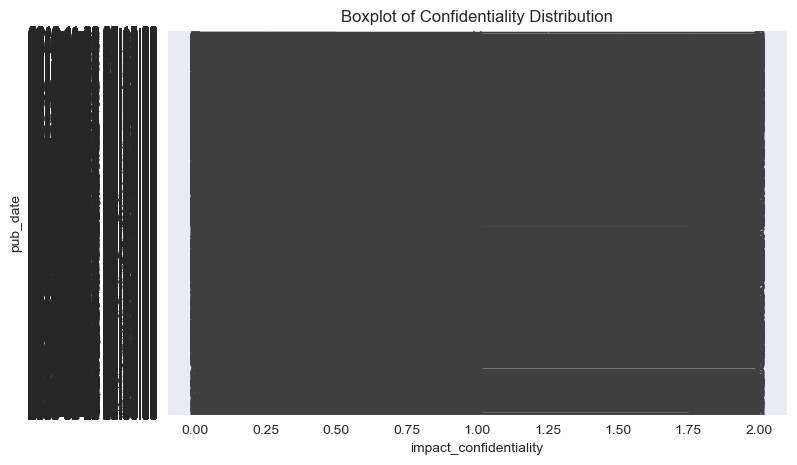

In [41]:
### 3.5 Quantiles and Interquartile Range (IQR)

# Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR for impact_confidentiality
q1_confidentiality = df["impact_confidentiality"].quantile(0.25)
q3_confidentiality = df["impact_confidentiality"].quantile(0.75)
iqr_confidentiality = q3_confidentiality - q1_confidentiality

print(f"Q1 (25th percentile of confidentiality): {q1_confidentiality:.2f}")
print(f"Q3 (75th percentile of confidentiality): {q3_confidentiality:.2f}")
print(f"Interquartile Range (IQR) of confidentiality: {iqr_confidentiality:.2f}")

# Visualize IQR using a boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["impact_confidentiality"], y=df["pub_date"])
plt.title("Boxplot of Confidentiality Distribution")
plt.show()



Mean (Expected Value): 0.8659
Variance: 0.5085
Standard Deviation: 0.7131


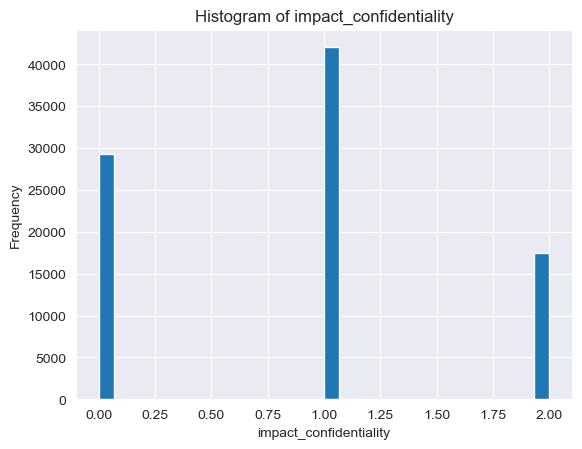

In [42]:
# ## 📊 4.Visualising Relationships

### 📊 4.1 Distribution Shapes

column_name = 'impact_confidentiality'

# Drop NaN values just in case
clean_impact_confidentiality = df[column_name].dropna()

# Mean, Variance, and Standard Deviation
mean_val = np.mean(clean_impact_confidentiality)
var_val = np.var(clean_impact_confidentiality, ddof=1)     # sample variance
std_val = np.std(clean_impact_confidentiality, ddof=1)     # sample standard deviation

print(f"Mean (Expected Value): {mean_val:.4f}")
print(f"Variance: {var_val:.4f}")
print(f"Standard Deviation: {std_val:.4f}")

# Visualize distribution
plt.hist(clean_impact_confidentiality, bins=30)
plt.title(f"Histogram of {column_name}")
plt.xlabel(column_name)
plt.ylabel("Frequency")
plt.show()

# Summary:
# The histogram shows the distribution of the impact_confidentiality values in our dataset.
#
# We also calculated key descriptive statistics:
#
# - The mean value of approximately 0.8659 indicates the average confidentiality values in the dataset.
# - The variance of 0.5085 tells us how spread out the values are — specifically, it’s the average of the squared differences from the mean.
# - The standard deviation of 0.7131 shows that most of the confidentiality values are within ±0.7131 units of the mean —
# a more interpretable measure than variance since it shares the same units as the data.
# - The histogram is asymmetric and slightly skewed, suggesting that the distribution is not perfectly normal.
# - There's a wide spread in the values, ranging from slightly below 15000 to above 40000.



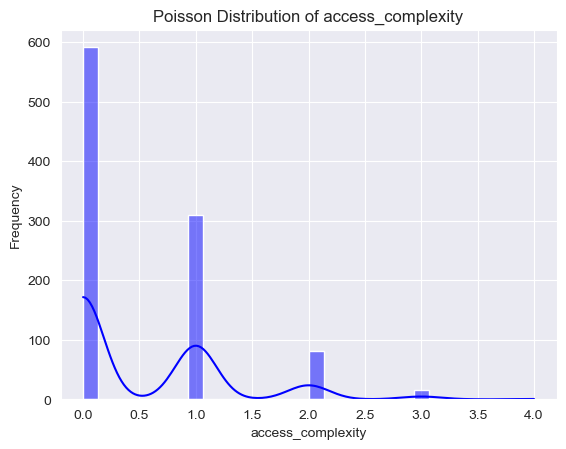

In [43]:
## 📊 4.2 Poisson distribution

# Estimate the mean of access_complexity
lambda_value = df["access_complexity"].mean()

# Generate Poisson distribution
poisson_data = np.random.poisson(lam=lambda_value, size=1000)

# Plot distribution
sns.histplot(poisson_data, kde=True, bins=30, color="blue")
plt.title("Poisson Distribution of access_complexity")
plt.xlabel("access_complexity")
plt.ylabel("Frequency")
plt.show()



Number of outliers detected per column:
 cvss                         1
cwe_code                  3026
access_authentication       23
access_complexity            0
access_vector                0
impact_availability          0
impact_confidentiality       0
impact_integrity             0
dtype: int64

--- Summary Statistics ---


,count,mean,std,min,25%,50%,75%,max
cvss,89660.0,6.021429,1.994757,0.0,4.3,5.8,7.5,10.0
cwe_code,89660.0,199.690854,176.177244,1.0,79.0,119.0,284.0,1188.0
access_authentication,88776.0,0.135419,0.342929,0.0,0.0,0.0,0.0,2.0
access_complexity,88776.0,0.512470,0.552613,0.0,0.0,0.0,1.0,2.0
access_vector,88776.0,1.744019,0.645709,0.0,2.0,2.0,2.0,2.0
impact_availability,88776.0,0.862609,0.758760,0.0,0.0,1.0,1.0,2.0
impact_confidentiality,88776.0,0.865943,0.713088,0.0,0.0,1.0,1.0,2.0
impact_integrity,88776.0,0.902079,0.684279,0.0,0.0,1.0,1.0,2.0



 Boxplots to Inspect Outliers:


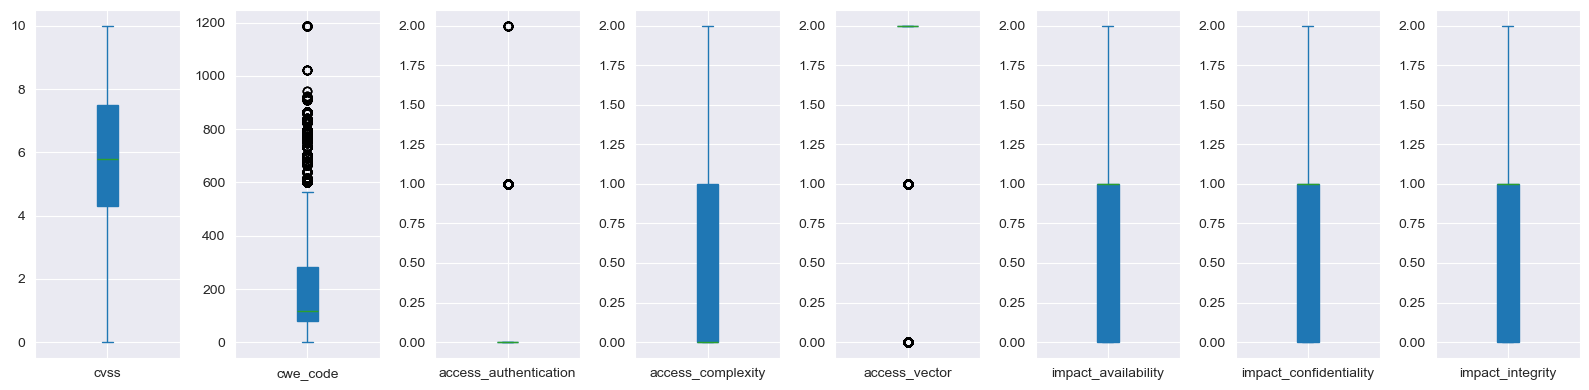

In [44]:
### 📦 4.3 Detect, Report, and Visualize Outliers Using Z-Score

# Detect, Report, and Visualize Outliers Using Z-Score

def visualize_outliers(df, threshold=3):
    df_numeric = df.select_dtypes(include=['number'])

    # Calculate Z-scores
    z_scores = df_numeric.apply(zscore, nan_policy='omit')

    # Count how many values are considered outliers
    outlier_counts = (z_scores.abs() > threshold).sum()
    print("Number of outliers detected per column:\n", outlier_counts)

    # Summary statistics
    print("\n--- Summary Statistics ---")
    display(df_numeric.describe().T)

    # Boxplot visualization
    print("\n Boxplots to Inspect Outliers:")
    df_numeric.plot(kind='box', subplots=True, layout=(1, len(df_numeric.columns)), figsize=(16, 4), patch_artist=True)
    plt.tight_layout()
    plt.show()

# Apply outlier visualization
visualize_outliers(df)



Covariance Matrix:
                       access_authentication  rolling_mean
access_authentication               0.117447      0.015170
rolling_mean                        0.015170      0.017262


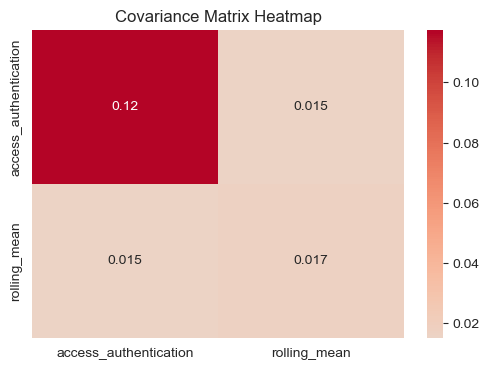

In [45]:
## 🔗 5. Analysing Correlation Between Variables

# Covariance Analysis

# Calculate a rolling mean to smooth out short-term fluctuations
df['rolling_mean'] = df['access_authentication'].rolling(window=30).mean()

# Remove rows with NaN values introduced by the rolling window
df_clean = df.dropna()

# Calculate the covariance matrix between the original values and their rolling mean
cov_matrix = df_clean[['access_authentication', 'rolling_mean']].cov()

# Display the covariance matrix
print("\nCovariance Matrix:")
print(cov_matrix)

# Visualize the covariance matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", center=0)

# Add plot title
plt.title("Covariance Matrix Heatmap")

# Show the plot
plt.show()




Pearson Correlation:
                       access_authentication  rolling_mean
access_authentication                    1.0          -1.0
rolling_mean                            -1.0           1.0

Spearman Correlation:
                       access_authentication  rolling_mean
access_authentication                    1.0          -1.0
rolling_mean                            -1.0           1.0

Kendall Correlation:
                       access_authentication  rolling_mean
access_authentication                    1.0          -1.0
rolling_mean                            -1.0           1.0


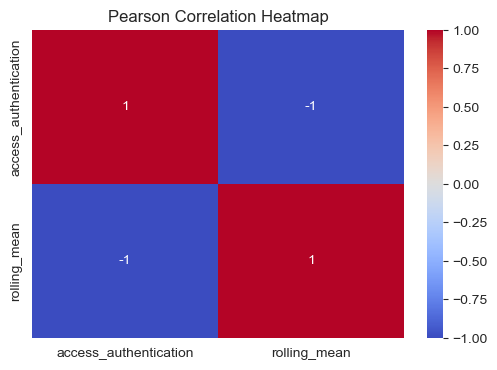

In [46]:
# Calculate correlation matrices using different methods:

pearson_corr = cov_matrix.corr(method='pearson') # - Pearson: linear correlation (assumes normality)
spearman_corr = cov_matrix.corr(method='spearman') # - Spearman: rank-based correlation (monotonic relationships)
kendall_corr = cov_matrix.corr(method='kendall') # - Kendall: rank correlation (more robust with small samples or ties)

# Display the correlation matrices
print("\nPearson Correlation:")
print(pearson_corr)

print("\nSpearman Correlation:")
print(spearman_corr)

print("\nKendall Correlation:")
print(kendall_corr)

plt.figure(figsize=(6, 4))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", center=0)

# Add title
plt.title("Pearson Correlation Heatmap")

# Show plot
plt.show()


In [48]:

# Linear Regression with Scikit-Learn

# Goal: Predict access_authentication based pub_date
df_clean = df.dropna()
# Define features (independent variable) and target (dependent variable)
X = df_clean[['pub_date']]  # Feature: smoothed version of the value
y = df_clean['access_authentication']  # Target: original value

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict values for the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print("\nModel Evaluation:")
print("Intercept:", model.intercept_)  # The constant term (β₀)
print("Coefficient:", model.coef_[0])  # The slope (β₁) for rolling_mean
print("R-squared:", r2_score(y_test, y_pred))  # Proportion of variance explained
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))  # Average squared error

plt.figure(figsize=(8, 5))  # Set the figure size

# Scatter plot of actual test data
plt.scatter(X_test, y_test, label='Actual', alpha=0.6)

# Plot regression line (predicted values)
plt.plot(X_test, y_pred, color='red', label='Predicted')

# Add labels and title
plt.xlabel("pub_date")
plt.ylabel("access_authentication")
plt.title("Linear Regression: pub_date vs access_authentication")

# Add legend and show the plot
plt.legend()
plt.show()

NameError: name 'train_test_split' is not defined